prep

In [1]:
import pandas as pd
import os
from itertools import combinations
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

os.getcwd()

base_dir = os.path.join("..", "data", "4v4_tournament_logs")

greedy_path = os.path.join(base_dir, "greedy_4player_game_logs_pt2.csv")
random_path = os.path.join(base_dir, "random_4player_game_logs_pt2.csv")

greedy_df = pd.read_csv(greedy_path)
random_df = pd.read_csv(random_path)

greedy_final = greedy_df.sort_values("round_id").groupby("game_id").tail(1)
random_final = random_df.sort_values("round_id").groupby("game_id").tail(1)


In [3]:
def compute_win_rate_by_player_index(final_df):
    position_wins = {0: 0, 1: 0, 2: 0, 3: 0}

    for _, row in final_df.iterrows():
        scores = [row[f"player_{i}_final"] for i in range(4)]
        max_score = max(scores)
        for i in range(4):
            if scores[i] == max_score:
                position_wins[i] += 1  

    total_games = final_df["game_id"].nunique()
    win_rates = {f"Player {i+1}": 100 * wins / total_games for i, wins in position_wins.items()}
    return pd.Series(win_rates)


In [4]:
greedy_final = greedy_df.sort_values("round_id").groupby("game_id").tail(1)
random_final = random_df.sort_values("round_id").groupby("game_id").tail(1)

greedy_win_rates = compute_win_rate_by_player_index(greedy_final)
random_win_rates = compute_win_rate_by_player_index(random_final)


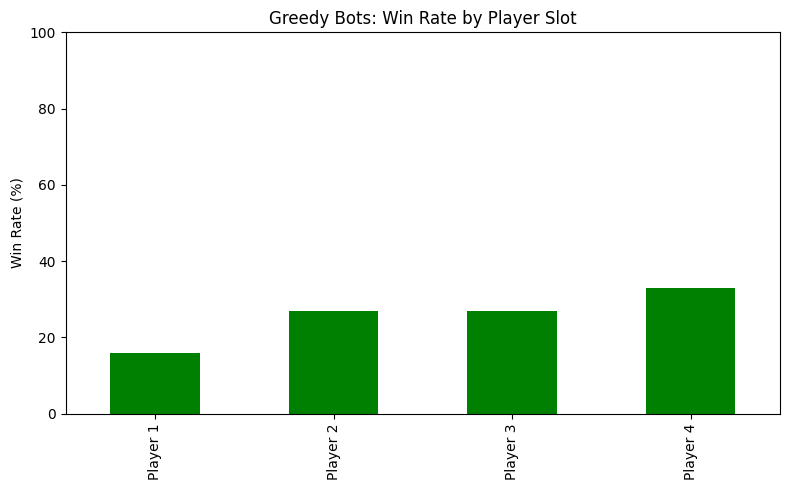

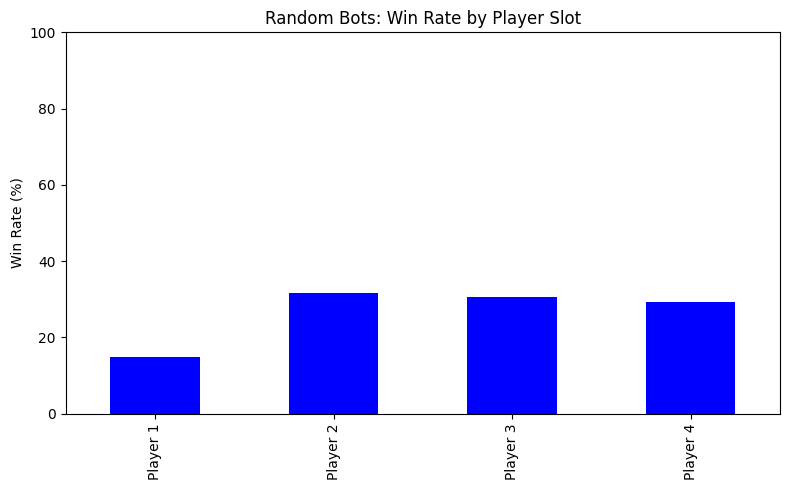

In [5]:
greedy_win_rates.plot(kind="bar", color="green", title="Greedy Bots: Win Rate by Player Slot", figsize=(8, 5))
plt.ylabel("Win Rate (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

random_win_rates.plot(kind="bar", color="blue", title="Random Bots: Win Rate by Player Slot", figsize=(8, 5))
plt.ylabel("Win Rate (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


In [6]:
def compute_rank_heatmap(final_df):
    rank_matrix = {i: [0, 0, 0, 0] for i in range(4)}  

    for _, row in final_df.iterrows():
        scores = np.array([row[f"player_{i}_final"] for i in range(4)])

        ranks = scores.argsort().argsort()

        for i in range(4):
            rank_matrix[i][ranks[i]] += 1  
    df = pd.DataFrame(rank_matrix).T
    df.columns = ["1st", "2nd", "3rd", "4th"]
    df.index = [f"Player {i+1}" for i in range(4)]

    df = df.div(df.sum(axis=1), axis=0) * 100
    return df.round(2)


In [7]:
greedy_final = greedy_df.sort_values("round_id").groupby("game_id").tail(1)
random_final = random_df.sort_values("round_id").groupby("game_id").tail(1)

greedy_rank_df = compute_rank_heatmap(greedy_final)
random_rank_df = compute_rank_heatmap(random_final)


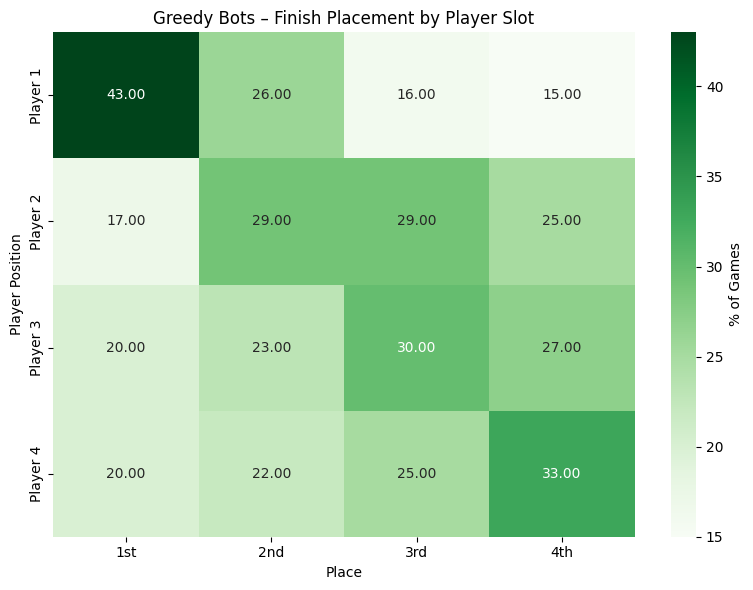

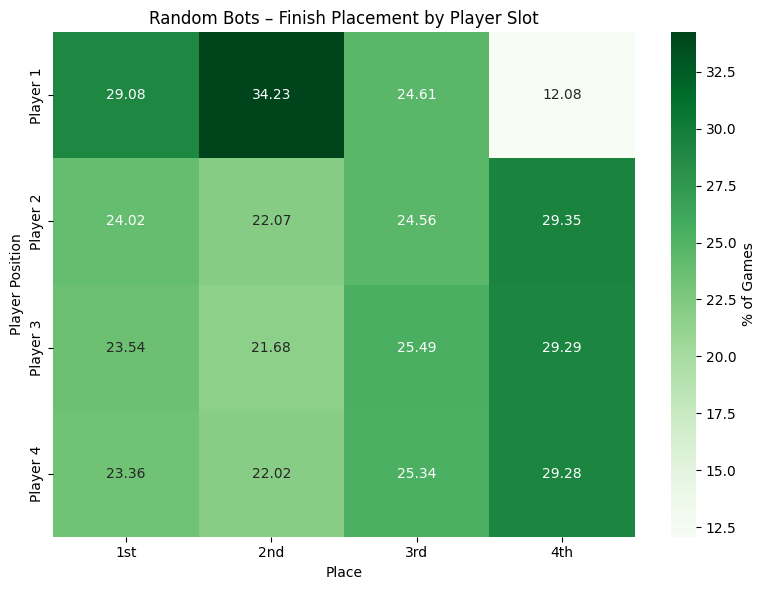

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(greedy_rank_df, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"label": "% of Games"})
plt.title("Greedy Bots – Finish Placement by Player Slot")
plt.xlabel("Place")
plt.ylabel("Player Position")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(random_rank_df, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"label": "% of Games"})
plt.title("Random Bots – Finish Placement by Player Slot")
plt.xlabel("Place")
plt.ylabel("Player Position")
plt.tight_layout()
plt.show()


In [9]:
mixed_path = os.path.join(base_dir, "mixed_4player_game_logs_pt2.csv")

mixed_df = pd.read_csv(mixed_path)

mixed_final = mixed_df.sort_values("round_id").groupby("game_id").tail(1)

In [10]:


def compute_true_rank_by_bot_type(df):
    placement_counts = defaultdict(lambda: [0, 0, 0, 0])  # bot → [1st, 2nd, 3rd, 4th]

    for _, row in df.iterrows():
        bot_scores = [
            (row["player_0_name"], row["player_0_final"]),
            (row["player_1_name"], row["player_1_final"]),
            (row["player_2_name"], row["player_2_final"]),
            (row["player_3_name"], row["player_3_final"]),
        ]

        sorted_bots = sorted(bot_scores, key=lambda x: x[1], reverse=True)

        for rank, (bot, _) in enumerate(sorted_bots):
            placement_counts[bot][rank] += 1

    df = pd.DataFrame(placement_counts).T
    df.columns = ["1st", "2nd", "3rd", "4th"]

    df = df.div(df.sum(axis=1), axis=0) * 100
    return df.round(2)

true_bot_rank_df = compute_true_rank_by_bot_type(mixed_df)



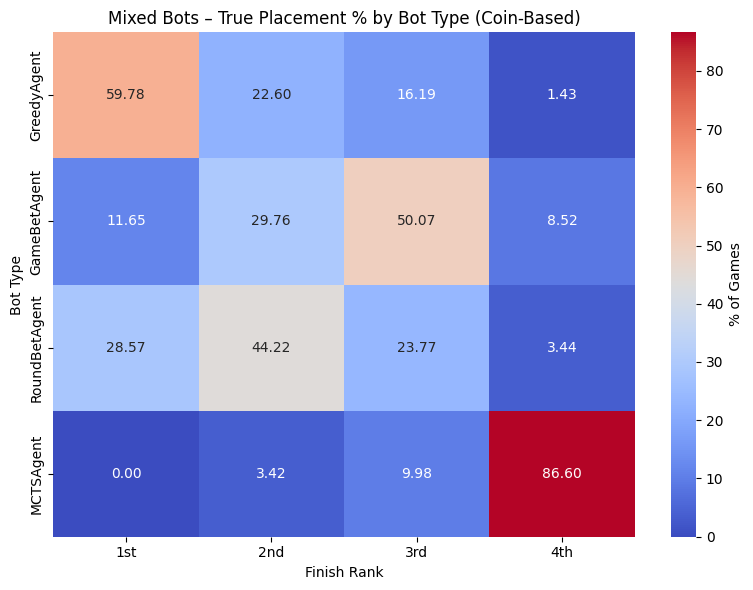

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(true_bot_rank_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "% of Games"})
plt.title("Mixed Bots – True Placement % by Bot Type (Coin-Based)")
plt.xlabel("Finish Rank")
plt.ylabel("Bot Type")
plt.tight_layout()
plt.show()


In [12]:
def rank_by_bot_and_position(df):
    # bot_type → player_index → [1st, 2nd, 3rd, 4th]
    data = defaultdict(lambda: defaultdict(lambda: [0, 0, 0, 0]))

    for _, row in df.iterrows():
        entries = [(i, row[f"player_{i}_name"], row[f"player_{i}_final"]) for i in range(4)]

        sorted_entries = sorted(entries, key=lambda x: x[2], reverse=True)
        for rank, (idx, bot, _) in enumerate(sorted_entries):
            data[bot][idx][rank] += 1

    records = []
    for bot, positions in data.items():
        for pos in range(4):
            total = sum(positions[pos])
            if total == 0:
                continue
            pct = [100 * count / total for count in positions[pos]]
            records.append((bot, pos + 1, *pct)) 

    return pd.DataFrame(records, columns=["Bot", "Player Slot", "1st", "2nd", "3rd", "4th"])

positional_df = rank_by_bot_and_position(mixed_df)


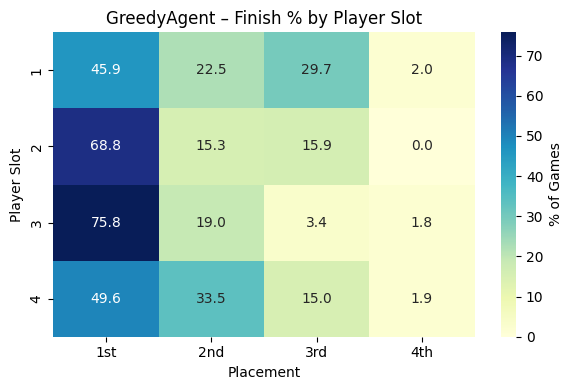

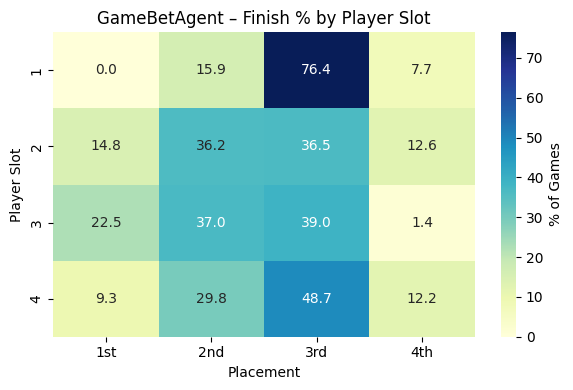

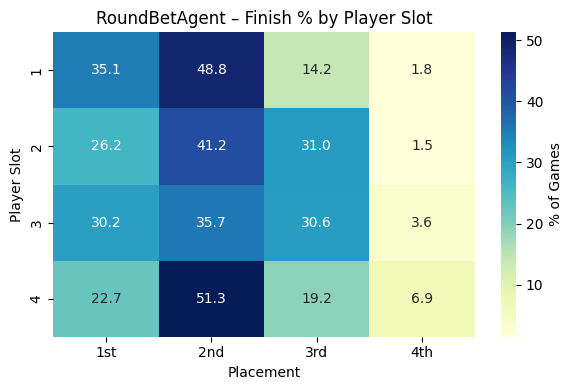

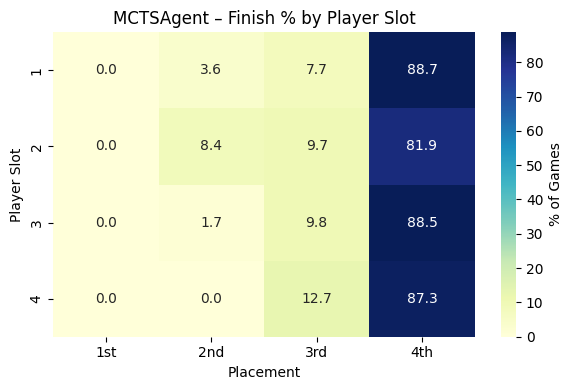

In [13]:
bots = positional_df["Bot"].unique()
for bot in bots:
    bot_data = positional_df[positional_df["Bot"] == bot].set_index("Player Slot")[["1st", "2nd", "3rd", "4th"]]
    plt.figure(figsize=(6, 4))
    sns.heatmap(bot_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "% of Games"})
    plt.title(f"{bot} – Finish % by Player Slot")
    plt.ylabel("Player Slot")
    plt.xlabel("Placement")
    plt.tight_layout()
    plt.show()


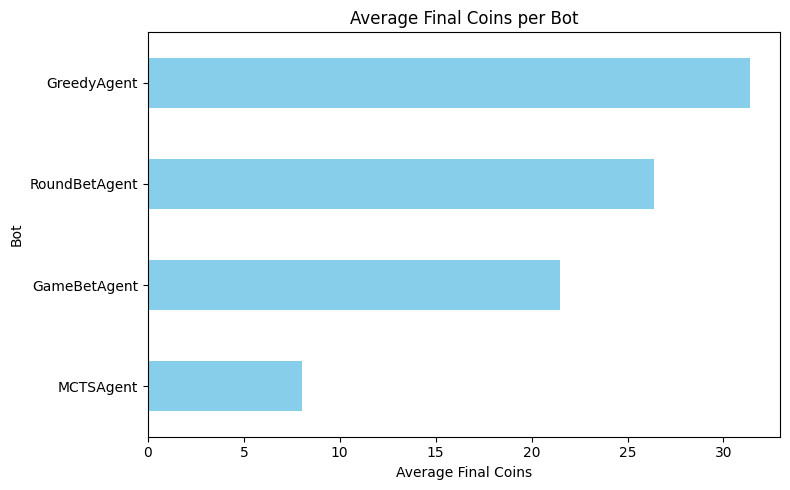

In [14]:
coin_records = []
for _, row in mixed_df.iterrows():
    for i in range(4):
        coin_records.append((row[f"player_{i}_name"], row[f"player_{i}_final"]))

coin_df = pd.DataFrame(coin_records, columns=["Bot", "Final Coins"])

avg_coins = coin_df.groupby("Bot")["Final Coins"].mean().sort_values()
avg_coins.plot(kind="barh", color="skyblue", title="Average Final Coins per Bot", figsize=(8, 5))
plt.xlabel("Average Final Coins")
plt.tight_layout()
plt.show()


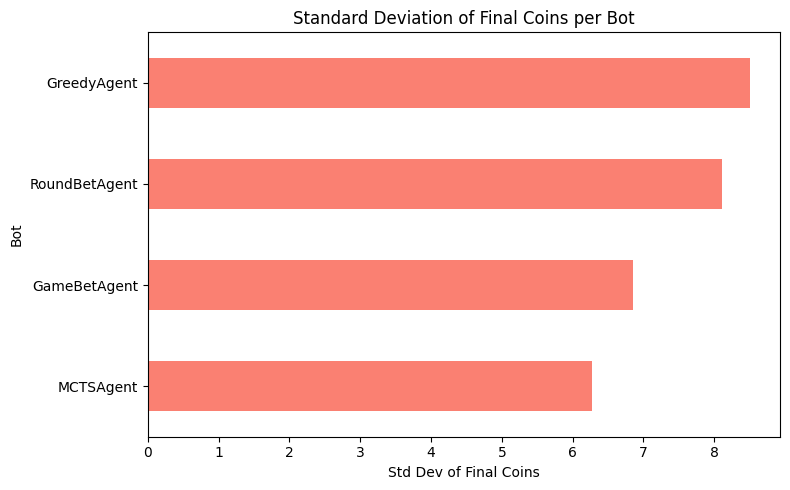

In [15]:
std_coins = coin_df.groupby("Bot")["Final Coins"].std().sort_values()

std_coins.plot(kind="barh", color="salmon", title="Standard Deviation of Final Coins per Bot", figsize=(8, 5))
plt.xlabel("Std Dev of Final Coins")
plt.tight_layout()
plt.show()


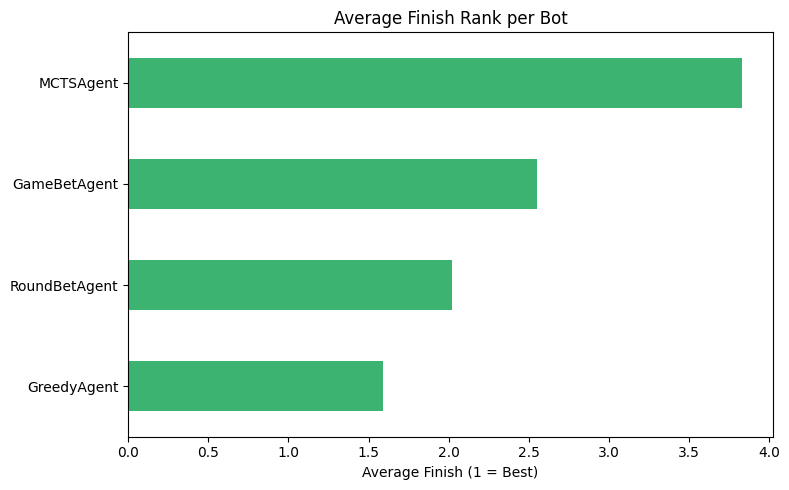

In [16]:
bot_ranks = defaultdict(list)

for _, row in mixed_df.iterrows():
    players = [(row[f"player_{i}_name"], row[f"player_{i}_final"]) for i in range(4)]
    sorted_players = sorted(players, key=lambda x: x[1], reverse=True)  

    for rank, (bot, _) in enumerate(sorted_players):
        bot_ranks[bot].append(rank + 1)  

avg_ranks = {bot: np.mean(ranks) for bot, ranks in bot_ranks.items()}
rank_df = pd.Series(avg_ranks).sort_values()

rank_df.plot(kind="barh", color="mediumseagreen", title="Average Finish Rank per Bot", figsize=(8, 5))
plt.xlabel("Average Finish (1 = Best)")
plt.tight_layout()
plt.show()


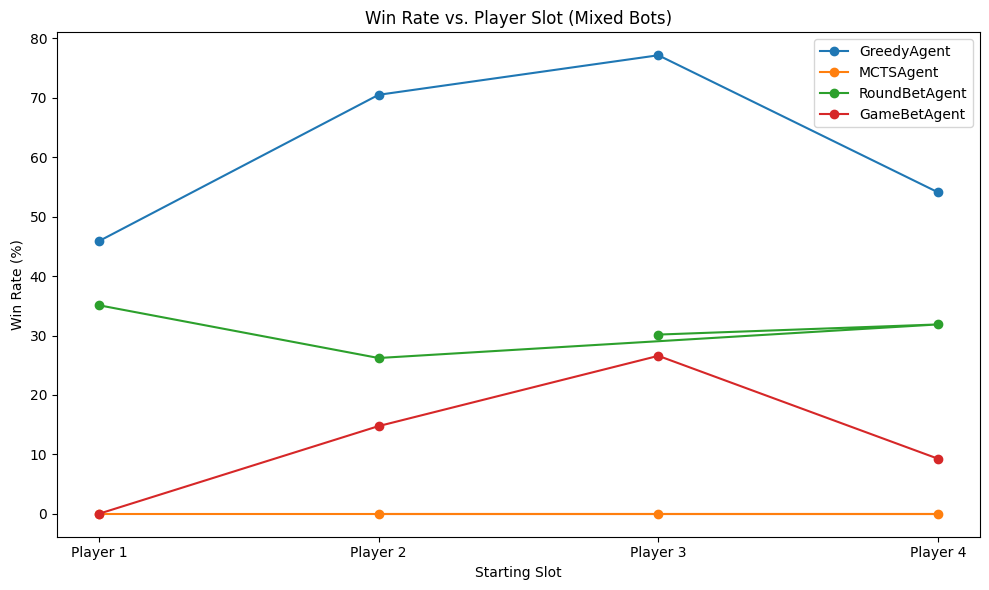

In [17]:
win_counts = defaultdict(int)
total_counts = defaultdict(int)

for _, row in mixed_df.iterrows():
    winners = row["winners"].split(", ")
    for i in range(4):
        bot = row[f"player_{i}_name"]
        slot = f"Player {i+1}"
        total_counts[(bot, slot)] += 1
        if bot in winners:
            win_counts[(bot, slot)] += 1

records = []
for (bot, slot), total in total_counts.items():
    wins = win_counts[(bot, slot)]
    win_rate = 100 * wins / total
    records.append((bot, slot, win_rate))

win_df = pd.DataFrame(records, columns=["Bot", "Player Slot", "Win Rate"])

plt.figure(figsize=(10, 6))
for bot in win_df["Bot"].unique():
    sub = win_df[win_df["Bot"] == bot]
    plt.plot(sub["Player Slot"], sub["Win Rate"], marker='o', label=bot)

plt.title("Win Rate vs. Player Slot (Mixed Bots)")
plt.ylabel("Win Rate (%)")
plt.xlabel("Starting Slot")
plt.legend()
plt.tight_layout()
plt.show()


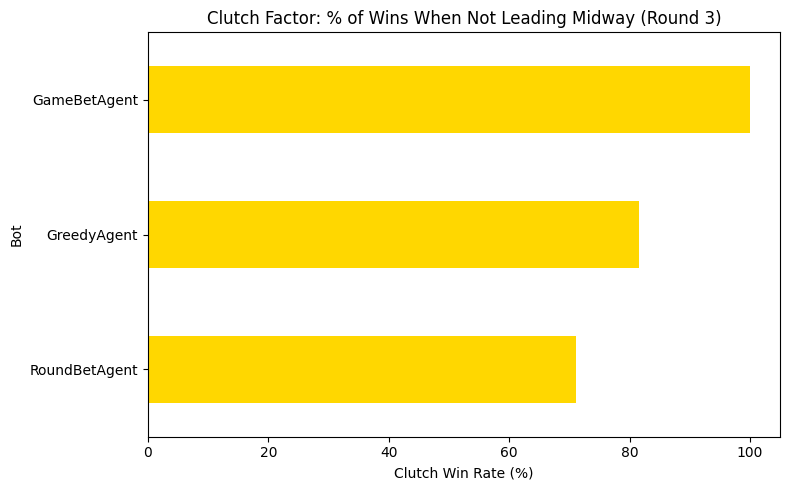

In [18]:
mid_rounds = mixed_df[mixed_df["round_id"] == 3].sort_values("round_id")

clutch_counter = Counter()
total_wins = Counter()

for game_id, final_row in mixed_df.groupby("game_id"):
    winners = final_row["winners"].values[0].split(", ")
    mid = mid_rounds[mid_rounds["game_id"] == game_id]

    if mid.empty:
        continue

    last_mid = mid.iloc[-1]
    mid_scores = [last_mid[f"player_{i}_coins"] for i in range(4)]
    mid_names = [last_mid[f"player_{i}_name"] for i in range(4)]
    leader = mid_names[np.argmax(mid_scores)]

    for winner in winners:
        total_wins[winner] += 1
        if winner != leader:
            clutch_counter[winner] += 1

clutch_df = pd.DataFrame({
    "Bot": list(total_wins.keys()),
    "Total Wins": [total_wins[bot] for bot in total_wins],
    "Clutch Wins": [clutch_counter[bot] for bot in total_wins],
})
clutch_df["Clutch %"] = 100 * clutch_df["Clutch Wins"] / clutch_df["Total Wins"]

clutch_df.set_index("Bot")["Clutch %"].sort_values().plot(kind="barh", color="gold", figsize=(8, 5))
plt.title("Clutch Factor: % of Wins When Not Leading Midway (Round 3)")
plt.xlabel("Clutch Win Rate (%)")
plt.tight_layout()
plt.show()


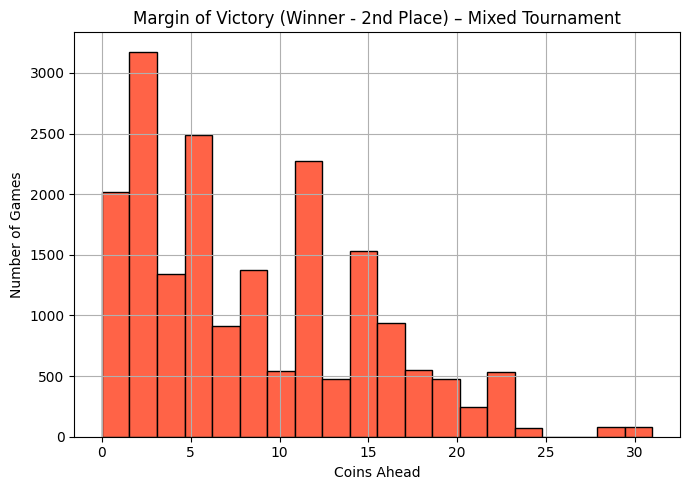

In [19]:
mov_list = []

for _, row in mixed_df.iterrows():
    scores = sorted([row[f"player_{i}_final"] for i in range(4)], reverse=True)
    if len(scores) >= 2:
        margin = scores[0] - scores[1]
        mov_list.append(margin)

plt.figure(figsize=(7, 5))
pd.Series(mov_list).hist(bins=20, color="tomato", edgecolor="black")
plt.title("Margin of Victory (Winner - 2nd Place) – Mixed Tournament")
plt.xlabel("Coins Ahead")
plt.ylabel("Number of Games")
plt.tight_layout()
plt.show()


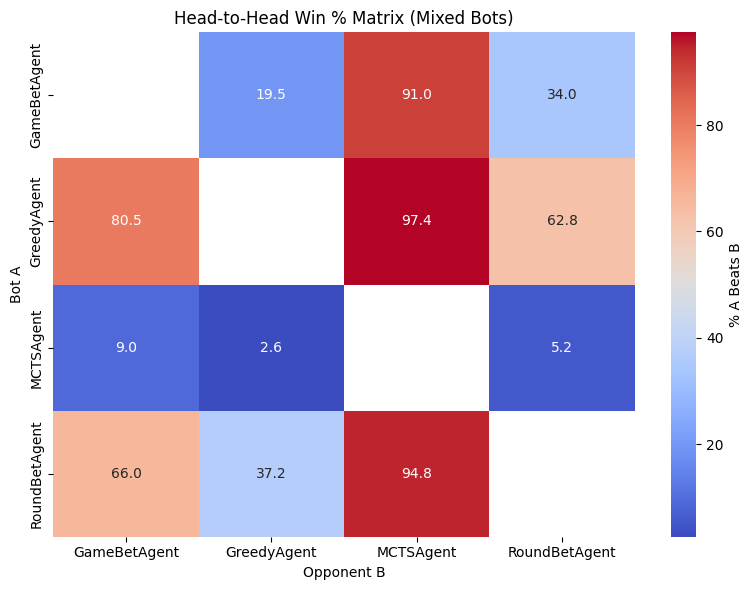

In [20]:


head_to_head = defaultdict(lambda: [0, 0])

for _, row in mixed_df.iterrows():
    players = [(row[f"player_{i}_name"], row[f"player_{i}_final"]) for i in range(4)]
    sorted_players = sorted(players, key=lambda x: x[1], reverse=True)
    bot_to_rank = {bot: rank for rank, (bot, _) in enumerate(sorted_players)}  # lower = better

    bots_in_game = [p[0] for p in players]
    for a, b in combinations(bots_in_game, 2):
        if a == b: continue  # shouldn't happen, but safe
        if bot_to_rank[a] < bot_to_rank[b]:
            head_to_head[(a, b)][0] += 1
        elif bot_to_rank[a] > bot_to_rank[b]:
            head_to_head[(b, a)][0] += 1
        head_to_head[(a, b)][1] += 1
        head_to_head[(b, a)][1] += 1

all_bots = sorted(set(bot for pair in head_to_head.keys() for bot in pair))
matrix = pd.DataFrame(index=all_bots, columns=all_bots, dtype=float)

for a in all_bots:
    for b in all_bots:
        if a == b:
            matrix.loc[a, b] = np.nan  
        else:
            wins, total = head_to_head.get((a, b), [0, 0])
            matrix.loc[a, b] = 100 * wins / total if total > 0 else np.nan

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% A Beats B"})
plt.title("Head-to-Head Win % Matrix (Mixed Bots)")
plt.xlabel("Opponent B")
plt.ylabel("Bot A")
plt.tight_layout()
plt.show()


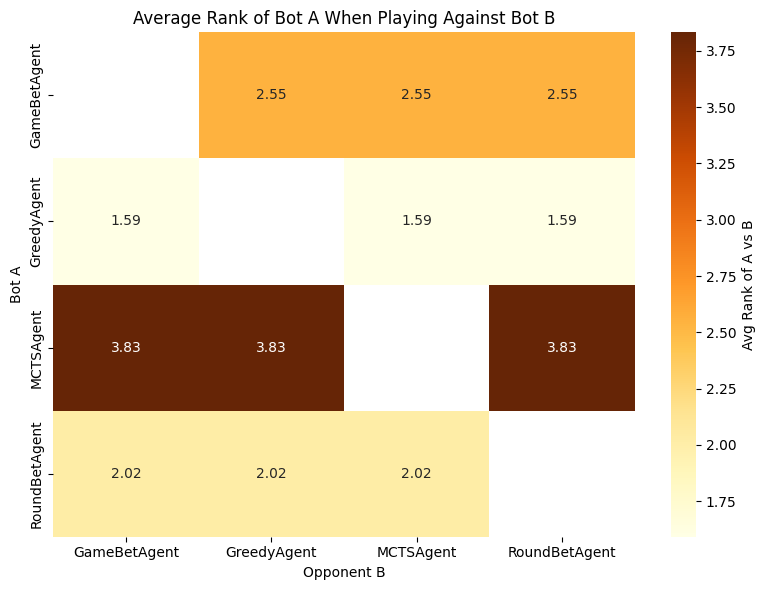

In [21]:
rank_against = defaultdict(list)

for _, row in mixed_df.iterrows():
    players = [(row[f"player_{i}_name"], row[f"player_{i}_final"]) for i in range(4)]
    sorted_players = sorted(players, key=lambda x: x[1], reverse=True)
    ranks = {bot: r+1 for r, (bot, _) in enumerate(sorted_players)}  # 1 = best

    bots = [bot for bot, _ in players]
    for a in bots:
        others = [b for b in bots if b != a]
        for b in others:
            rank_against[(a, b)].append(ranks[a])

bots = sorted(set(bot for pair in rank_against for bot in pair))
rank_matrix = pd.DataFrame(index=bots, columns=bots, dtype=float)

for a in bots:
    for b in bots:
        if a == b:
            rank_matrix.loc[a, b] = np.nan
        else:
            ranks = rank_against.get((a, b), [])
            rank_matrix.loc[a, b] = np.mean(ranks) if ranks else np.nan

plt.figure(figsize=(8, 6))
sns.heatmap(rank_matrix, annot=True, fmt=".2f", cmap="YlOrBr", cbar_kws={"label": "Avg Rank of A vs B"})
plt.title("Average Rank of Bot A When Playing Against Bot B")
plt.xlabel("Opponent B")
plt.ylabel("Bot A")
plt.tight_layout()
plt.show()


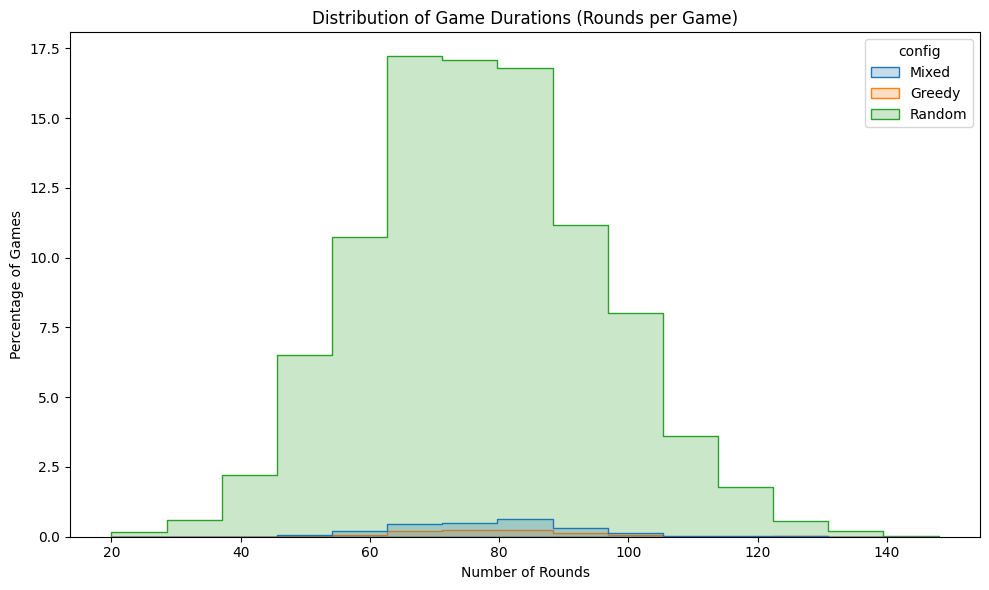

In [22]:
def prep_duration_df(df, label):
    return df.groupby("game_id")["round_id"].max().reset_index().assign(config=label)

mixed_dur = prep_duration_df(mixed_df, "Mixed")
greedy_dur = prep_duration_df(greedy_df, "Greedy")
random_dur = prep_duration_df(random_df, "Random")

all_durations = pd.concat([mixed_dur, greedy_dur, random_dur])

plt.figure(figsize=(10, 6))
sns.histplot(data=all_durations, x="round_id", hue="config", element="step", bins=15, stat="percent")
plt.title("Distribution of Game Durations (Rounds per Game)")
plt.xlabel("Number of Rounds")
plt.ylabel("Percentage of Games")
plt.tight_layout()
plt.show()


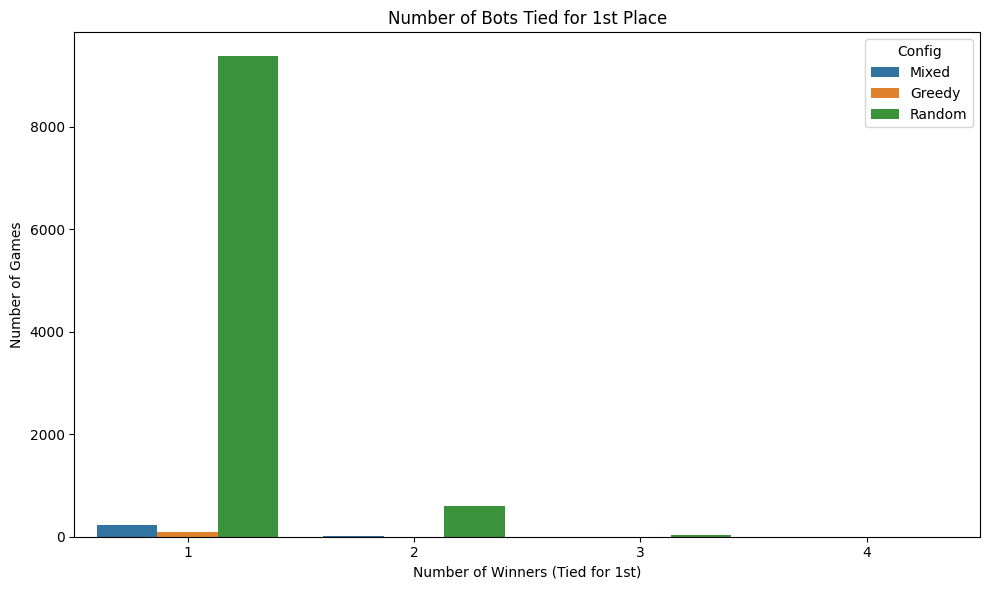

In [23]:
def get_final_rows(df):
    return df.sort_values("round_id").groupby("game_id").tail(1)

final_mixed = get_final_rows(mixed_df)
final_greedy = get_final_rows(greedy_df)
final_random = get_final_rows(random_df)

def count_ties(df, label):
    return df["winners"].apply(lambda w: len(w.split(", "))).value_counts().rename_axis("Num Winners").reset_index(name="Game Count").assign(Config=label)

mixed_ties = count_ties(final_mixed, "Mixed")
greedy_ties = count_ties(final_greedy, "Greedy")
random_ties = count_ties(final_random, "Random")

all_ties = pd.concat([mixed_ties, greedy_ties, random_ties])

plt.figure(figsize=(10, 6))
sns.barplot(data=all_ties, x="Num Winners", y="Game Count", hue="Config")
plt.title("Number of Bots Tied for 1st Place")
plt.xlabel("Number of Winners (Tied for 1st)")
plt.ylabel("Number of Games")
plt.tight_layout()
plt.show()


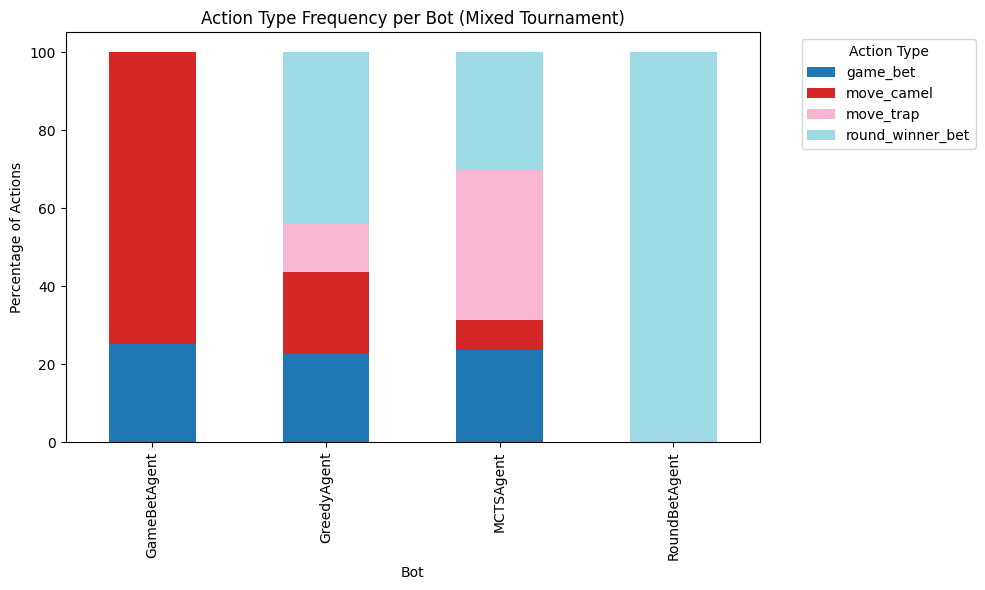

In [24]:
records = []
for _, row in mixed_df.iterrows():
    if "active_player" not in row or pd.isna(row["active_player"]):
        continue
    try:
        i = int(row["active_player"])
        bot_name = row[f"player_{i}_name"]
        action = row["action_type"]
        if pd.notna(bot_name) and pd.notna(action):
            records.append((bot_name, action))
    except Exception:
        continue

action_df = pd.DataFrame(records, columns=["Bot", "Action"])

if not action_df.empty:
    action_counts = pd.crosstab(action_df["Bot"], action_df["Action"], normalize="index") * 100
    action_counts = action_counts.apply(pd.to_numeric, errors='coerce').fillna(0).round(1)

    action_counts.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20")
    plt.title("Action Type Frequency per Bot (Mixed Tournament)")
    plt.ylabel("Percentage of Actions")
    plt.xlabel("Bot")
    plt.legend(title="Action Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No action data available to plot.")


In [25]:
base_dir = os.path.join("..", "data", "4v4_tournament_logs")

fixed_greedy_path = os.path.join(base_dir, "fixed_order_4player_game_logs_pt2.csv")
df = pd.read_csv(fixed_greedy_path)

game_win_bets = df[(df["action_type"] == "game_bet") & (df["bet_type"] == "lose")].copy()

def get_position_at_bet(row):
    camel_idx = row["camel"]
    return row[f"camel_{camel_idx}_location"]

game_win_bets["camel_position"] = game_win_bets.apply(get_position_at_bet, axis=1)

avg_pos = game_win_bets["camel_position"].mean().round(2)

print(f"✅ Average position of the camel when lose game bet was made: {avg_pos}")


✅ Average position of the camel when lose game bet was made: 2.66


In [26]:
base_dir = os.path.join("..", "data", "4v4_tournament_logs")

fixed_greedy_path = os.path.join(base_dir, "fixed_order_4player_game_logs_pt2.csv")
df = pd.read_csv(fixed_greedy_path)

final_rows = df.groupby("game_id").tail(1)

# Track wins by coin totals
coin_wins = {f"player_{i}": 0 for i in range(4)}
total_games = final_rows["game_id"].nunique()

# Find the winning player based on coins
for _, row in final_rows.iterrows():
    coin_totals = {f"player_{i}": row[f"player_{i}_coins"] for i in range(4)}
    winning_player = max(coin_totals, key=coin_totals.get)
    coin_wins[winning_player] += 1

# Convert to percentage
coin_winrates = {pos: wins / total_games * 100 for pos, wins in coin_wins.items()}

# Create DataFrame for LaTeX
coin_df = pd.DataFrame([
    {"Player": k.replace("_", " ").title(), "Win Rate (%)": f"{v:.2f}"}
    for k, v in coin_winrates.items()
])

display(coin_df)

,Player,Win Rate (%)
0,Player 0,0.00
1,Player 1,1.67
2,Player 2,88.00
3,Player 3,10.33


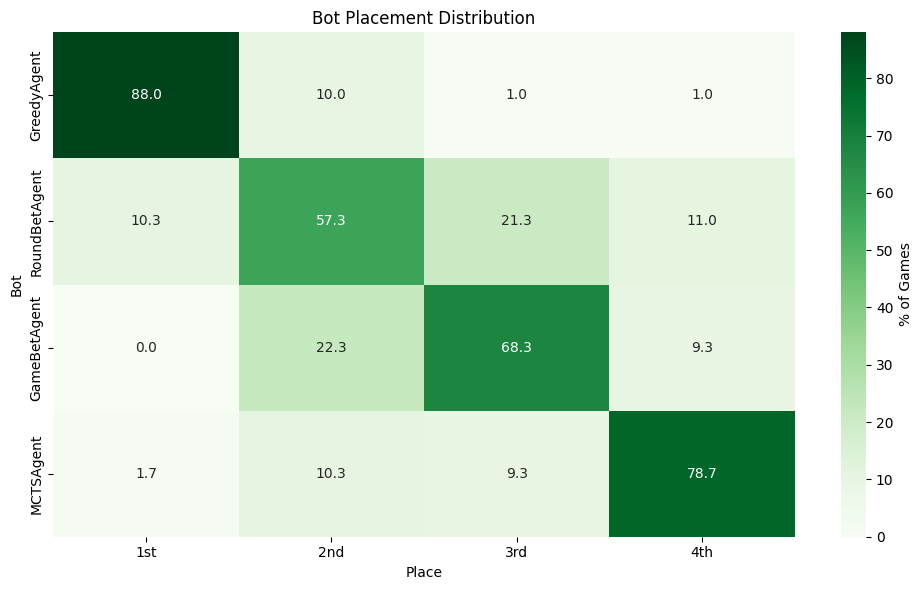

In [27]:
base_dir = os.path.join("..", "data", "4v4_tournament_logs")

fixed_greedy_path = os.path.join(base_dir, "fixed_order_4player_game_logs_pt2.csv")
df = pd.read_csv(fixed_greedy_path)

finals = df.groupby("game_id").tail(1)

placement_counts = {}

for _, row in finals.iterrows():
    player_scores = [(i, row[f"player_{i}_name"], row[f"player_{i}_coins"]) for i in range(4)]
    max_coin = max(score for _, _, score in player_scores)
    
    tied_players = [(slot, name) for slot, name, score in player_scores if score == max_coin]
    greedy_in_tie = any(name == "GreedyAgent" for _, name in tied_players)
    
    sorted_players = sorted(player_scores, key=lambda x: x[2], reverse=True)
    
    for place, (slot, bot, score) in enumerate(sorted_players):
        if bot not in placement_counts:
            placement_counts[bot] = [0, 0, 0, 0]

        if place == 0:
            if len(tied_players) > 1:
                if bot == "GreedyAgent":
                    placement_counts[bot][0] += 1  
                else:
                    placement_counts[bot][1] += 1  
            else:
                placement_counts[bot][0] += 1
        else:
            placement_counts[bot][place] += 1

placement_df = pd.DataFrame(placement_counts, index=["1st", "2nd", "3rd", "4th"]).T

placement_percent = placement_df.div(placement_df.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(placement_percent, annot=True, fmt=".1f", cmap="Greens", cbar_kws={'label': '% of Games'})
plt.title("Bot Placement Distribution")
plt.xlabel("Place")
plt.ylabel("Bot")
plt.tight_layout()
plt.show()


In [28]:
placement_counts = {}
for _, row in finals.iterrows():
    player_scores = [(i, row[f"player_{i}_name"], row[f"player_{i}_coins"]) for i in range(4)]
    max_coin = max(score for _, _, score in player_scores)
    tied_players = [(slot, name) for slot, name, score in player_scores if score == max_coin]
    sorted_players = sorted(player_scores, key=lambda x: x[2], reverse=True)

    for place, (slot, bot, score) in enumerate(sorted_players):
        if bot not in placement_counts:
            placement_counts[bot] = [0, 0, 0, 0]
        if place == 0:
            if len(tied_players) > 1:
                if bot == "GreedyAgent":
                    placement_counts[bot][0] += 1
                else:
                    placement_counts[bot][1] += 1
            else:
                placement_counts[bot][0] += 1
        else:
            placement_counts[bot][place] += 1

summary_stats = []
all_bots = df[[f"player_{i}_name" for i in range(4)]].stack().unique()

for bot in all_bots:
    bot_games = []

    for _, row in finals.iterrows():
        for i in range(4):
            if row[f"player_{i}_name"] == bot:
                coins = row[f"player_{i}_coins"]
                all_coins = [row[f"player_{j}_coins"] for j in range(4)]
                margin = coins - sum(all_coins) / 4
                bot_games.append({"coins": coins, "margin": margin})

    if not bot_games:
        continue

    coins_list = [g["coins"] for g in bot_games]
    margins = [g["margin"] for g in bot_games]

    summary_stats.append({
        "Bot": bot,
        "Win %": (placement_counts[bot][0] / sum(placement_counts[bot])) * 100 if bot in placement_counts else 0,
        "Avg": round(pd.Series(coins_list).mean(), 1),
        "Var": round(pd.Series(coins_list).var(), 1),
        "Min": round(pd.Series(coins_list).min(), 0),
        "Max": round(pd.Series(coins_list).max(), 0),
        "Margin": round(pd.Series(margins).mean(), 1)
    })

summary_df = pd.DataFrame(summary_stats)

K = 32
elo_scores = {bot: 1000 for bot in all_bots}

for _, row in finals.iterrows():
    bots = [(row[f"player_{i}_name"], row[f"player_{i}_coins"]) for i in range(4)]
    bots = sorted(bots, key=lambda x: x[1], reverse=True)
    
    top_score = bots[0][1]
    tied = [bot for bot, coins in bots if coins == top_score]
    winner = "GreedyAgent" if "GreedyAgent" in tied else tied[0]
    
    for i in range(4):
        for j in range(i + 1, 4):
            bot_i, score_i = bots[i]
            bot_j, score_j = bots[j]

            # S_i = 1 if i beat j, 0 otherwise
            if bot_i == bot_j:
                continue
            S_i = 1 if i < j else 0
            E_i = 1 / (1 + 10 ** ((elo_scores[bot_j] - elo_scores[bot_i]) / 400))
            elo_scores[bot_i] += K * (S_i - E_i)
            elo_scores[bot_j] += K * ((1 - S_i) - (1 - E_i))

summary_df["ELO"] = summary_df["Bot"].map(elo_scores)
summary_df = summary_df[["Bot", "ELO", "Win %", "Avg", "Var", "Min", "Max", "Margin"]]
summary_df = summary_df.sort_values(by="ELO", ascending=False).reset_index(drop=True)

print(summary_df)


             Bot          ELO      Win %   Avg   Var  Min  Max  Margin
0    GreedyAgent  1431.158909  88.000000  35.6  85.7    9   64    14.3
1  RoundBetAgent   990.310176  10.333333  22.1  46.6    5   44     0.8
2   GameBetAgent   839.913779   0.000000  17.5  10.0    8   29    -3.7
3      MCTSAgent   738.617136   1.666667   9.8  62.7   -8   35   -11.4


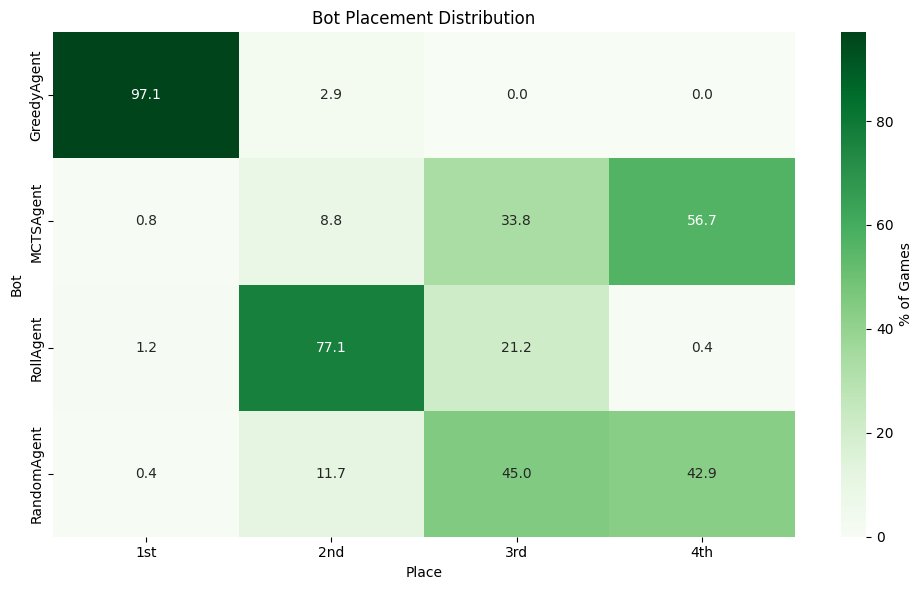

In [29]:
base_dir = os.path.join("..", "data", "four_player_tournament_pt2")

easy_greedy_path = os.path.join(base_dir, "mixed_4player_game_logs_pt3.csv")
df = pd.read_csv(easy_greedy_path)

finals = df.groupby("game_id").tail(1)

placement_counts = {}

for _, row in finals.iterrows():
    player_scores = [(i, row[f"player_{i}_name"], row[f"player_{i}_coins"]) for i in range(4)]
    max_coin = max(score for _, _, score in player_scores)
    
    tied_players = [(slot, name) for slot, name, score in player_scores if score == max_coin]
    greedy_in_tie = any(name == "GreedyAgent" for _, name in tied_players)
    
    sorted_players = sorted(player_scores, key=lambda x: x[2], reverse=True)
    
    for place, (slot, bot, score) in enumerate(sorted_players):
        if bot not in placement_counts:
            placement_counts[bot] = [0, 0, 0, 0]

        if place == 0:
            if len(tied_players) > 1:
                if bot == "GreedyAgent":
                    placement_counts[bot][0] += 1  
                else:
                    placement_counts[bot][1] += 1  
            else:
                placement_counts[bot][0] += 1
        else:
            placement_counts[bot][place] += 1

placement_df = pd.DataFrame(placement_counts, index=["1st", "2nd", "3rd", "4th"]).T

placement_percent = placement_df.div(placement_df.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(placement_percent, annot=True, fmt=".1f", cmap="Greens", cbar_kws={'label': '% of Games'})
plt.title("Bot Placement Distribution")
plt.xlabel("Place")
plt.ylabel("Bot")
plt.tight_layout()
plt.show()


In [30]:
placement_counts = {}
for _, row in finals.iterrows():
    player_scores = [(i, row[f"player_{i}_name"], row[f"player_{i}_coins"]) for i in range(4)]
    max_coin = max(score for _, _, score in player_scores)
    tied_players = [(slot, name) for slot, name, score in player_scores if score == max_coin]
    sorted_players = sorted(player_scores, key=lambda x: x[2], reverse=True)

    for place, (slot, bot, score) in enumerate(sorted_players):
        if bot not in placement_counts:
            placement_counts[bot] = [0, 0, 0, 0]
        if place == 0:
            if len(tied_players) > 1:
                if bot == "GreedyAgent":
                    placement_counts[bot][0] += 1
                else:
                    placement_counts[bot][1] += 1
            else:
                placement_counts[bot][0] += 1
        else:
            placement_counts[bot][place] += 1

summary_stats = []
all_bots = df[[f"player_{i}_name" for i in range(4)]].stack().unique()

for bot in all_bots:
    bot_games = []

    for _, row in finals.iterrows():
        for i in range(4):
            if row[f"player_{i}_name"] == bot:
                coins = row[f"player_{i}_coins"]
                all_coins = [row[f"player_{j}_coins"] for j in range(4)]
                margin = coins - sum(all_coins) / 4
                bot_games.append({"coins": coins, "margin": margin})

    if not bot_games:
        continue

    coins_list = [g["coins"] for g in bot_games]
    margins = [g["margin"] for g in bot_games]

    summary_stats.append({
        "Bot": bot,
        "Win %": (placement_counts[bot][0] / sum(placement_counts[bot])) * 100 if bot in placement_counts else 0,
        "Avg": round(pd.Series(coins_list).mean(), 1),
        "Var": round(pd.Series(coins_list).var(), 1),
        "Min": round(pd.Series(coins_list).min(), 0),
        "Max": round(pd.Series(coins_list).max(), 0),
        "Margin": round(pd.Series(margins).mean(), 1)
    })

summary_df = pd.DataFrame(summary_stats)

K = 32
elo_scores = {bot: 1000 for bot in all_bots}

for _, row in finals.iterrows():
    bots = [(row[f"player_{i}_name"], row[f"player_{i}_coins"]) for i in range(4)]
    bots = sorted(bots, key=lambda x: x[1], reverse=True)
    
    top_score = bots[0][1]
    tied = [bot for bot, coins in bots if coins == top_score]
    winner = "GreedyAgent" if "GreedyAgent" in tied else tied[0]
    
    for i in range(4):
        for j in range(i + 1, 4):
            bot_i, score_i = bots[i]
            bot_j, score_j = bots[j]

            # S_i = 1 if i beat j, 0 otherwise
            if bot_i == bot_j:
                continue
            S_i = 1 if i < j else 0
            E_i = 1 / (1 + 10 ** ((elo_scores[bot_j] - elo_scores[bot_i]) / 400))
            elo_scores[bot_i] += K * (S_i - E_i)
            elo_scores[bot_j] += K * ((1 - S_i) - (1 - E_i))

summary_df["ELO"] = summary_df["Bot"].map(elo_scores)
summary_df = summary_df[["Bot", "ELO", "Win %", "Avg", "Var", "Min", "Max", "Margin"]]
summary_df = summary_df.sort_values(by="ELO", ascending=False).reset_index(drop=True)

print(summary_df)


           Bot          ELO      Win %   Avg   Var  Min  Max  Margin
0  GreedyAgent  1660.330222  97.083333  36.9  97.2   12   68    18.7
1    RollAgent  1026.472949   1.250000  17.5  10.5    9   26    -0.7
2    MCTSAgent   687.910477   0.833333   8.8  44.0   -4   31    -9.4
3  RandomAgent   625.286352   0.416667   9.6  34.2   -3   28    -8.6


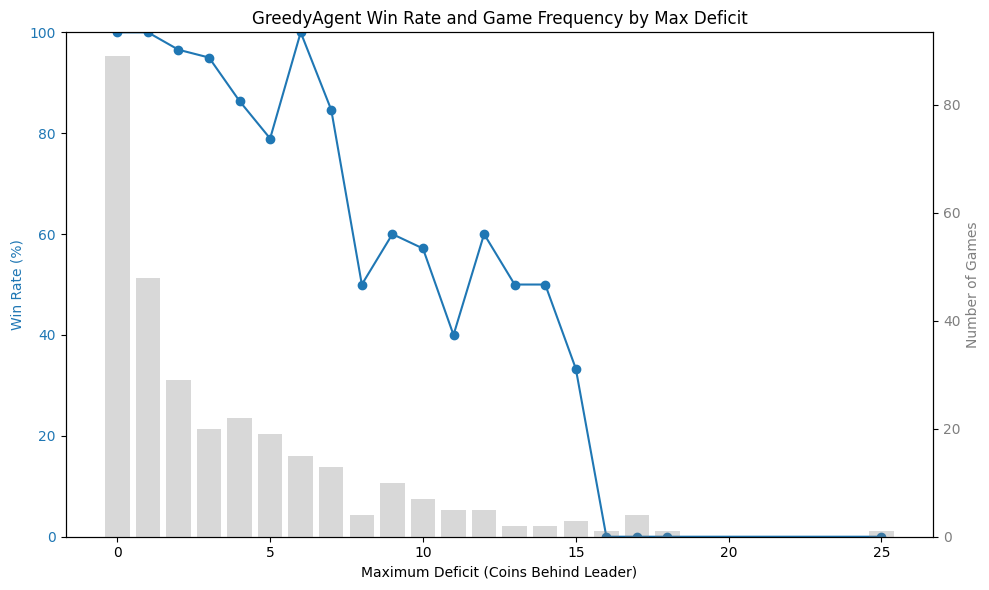

In [31]:
base_dir = os.path.join("..", "data", "four_player_tournament_pt2")

easy_greedy_path = os.path.join(base_dir, "fixed_order_4player_game_logs_pt2.csv")
df = pd.read_csv(easy_greedy_path)

df_valid = df[df["active_player"].notna()].copy()

df_valid["active_player_name"] = df_valid.apply(
    lambda row: row[f"player_{int(row['active_player'])}_name"], axis=1
)

greedy_trail_records = []
for game_id, game_df in df_valid.groupby("game_id"):
    greedy_deficits = []

    for _, row in game_df.iterrows():
        coins = [row[f"player_{i}_coins"] for i in range(4)]
        names = [row[f"player_{i}_name"] for i in range(4)]
        if "GreedyAgent" not in names:
            continue
        greedy_index = names.index("GreedyAgent")
        greedy_score = coins[greedy_index]
        max_other = max(c for i, c in enumerate(coins) if i != greedy_index)
        deficit = max(0, max_other - greedy_score)
        greedy_deficits.append(deficit)

    if not greedy_deficits:
        continue

    max_deficit = max(greedy_deficits)

    final_row = game_df.iloc[-1]
    final_scores = [(final_row[f"player_{i}_name"], final_row[f"player_{i}_coins"]) for i in range(4)]
    sorted_scores = sorted(final_scores, key=lambda x: x[1], reverse=True)
    winner = sorted_scores[0][0]
    if len([s for s in sorted_scores if s[1] == sorted_scores[0][1]]) > 1:
        winner = "GreedyAgent" if "GreedyAgent" in [s[0] for s in sorted_scores if s[1] == sorted_scores[0][1]] else "Other"

    greedy_trail_records.append({
        "game_id": game_id,
        "max_deficit": int(max_deficit),
        "won": winner == "GreedyAgent"
    })

trail_df = pd.DataFrame(greedy_trail_records)

win_rate_by_deficit = trail_df.groupby("max_deficit")["won"].agg(["mean", "count"]).reset_index()
win_rate_by_deficit.columns = ["max_deficit", "win_rate", "num_games"]
win_rate_by_deficit["win_percent"] = 100 * win_rate_by_deficit["win_rate"]

fig, ax1 = plt.subplots(figsize=(10, 6))

color = "tab:blue"
ax1.set_xlabel("Maximum Deficit (Coins Behind Leader)")
ax1.set_ylabel("Win Rate (%)", color=color)
ax1.plot(win_rate_by_deficit["max_deficit"], win_rate_by_deficit["win_percent"],
         color=color, marker='o', label="Win Rate")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 100)

ax2 = ax1.twinx()
color = "tab:gray"
ax2.set_ylabel("Number of Games", color=color)
ax2.bar(win_rate_by_deficit["max_deficit"], win_rate_by_deficit["num_games"],
        alpha=0.3, color=color, label="Game Count")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("GreedyAgent Win Rate and Game Frequency by Max Deficit")
fig.tight_layout()
plt.show()
